In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver


In [2]:
memory = MemorySaver()

class State(TypedDict):
    value: str


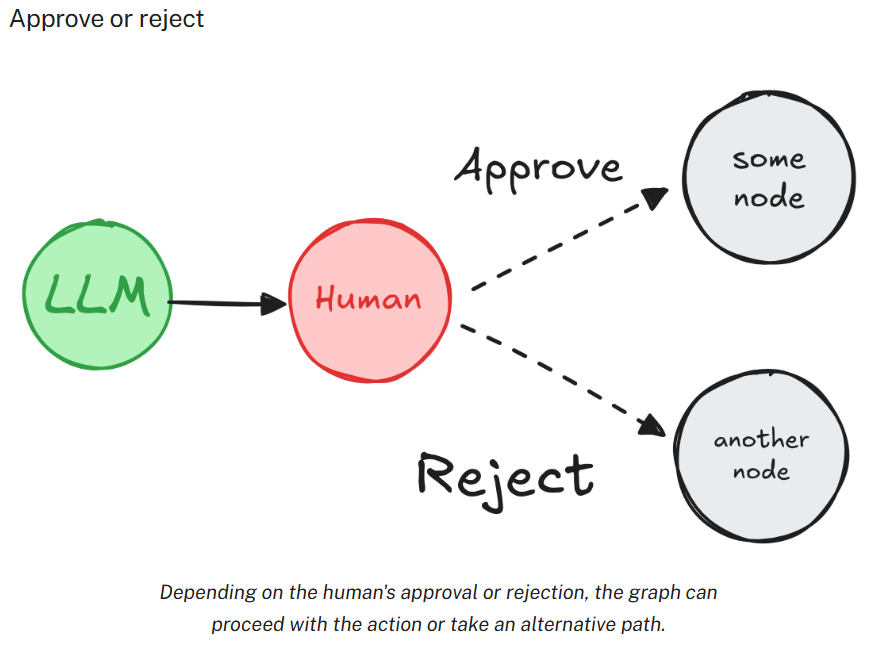

In [3]:
def node_a(state: State): 
    print("Node A")
    return Command(
        goto="node_b", 
        update={
            "value": state["value"] + "a"
        }
    )

def node_b(state: State): 
    print("Node B")

    human_response = interrupt("Do you want to go to C or D? Type C/D")

    print("Human Review Values: ", human_response)
    
    if(human_response == "C"): 
        return Command(
            goto="node_c", 
            update={
                "value": state["value"] + "b"
            }
        ) 
    elif(human_response == "D"): 
        return Command(
            goto="node_d", 
            update={
                "value": state["value"] + "b"
            }
        )


def node_c(state: State): 
    print("Node C")
    return Command(
        goto=END, 
        update={
            "value": state["value"] + "c"
        }
    )

def node_d(state: State): 
    print("Node D")
    return Command(
        goto=END, 
        update={
            "value": state["value"] + "d"
        }
)

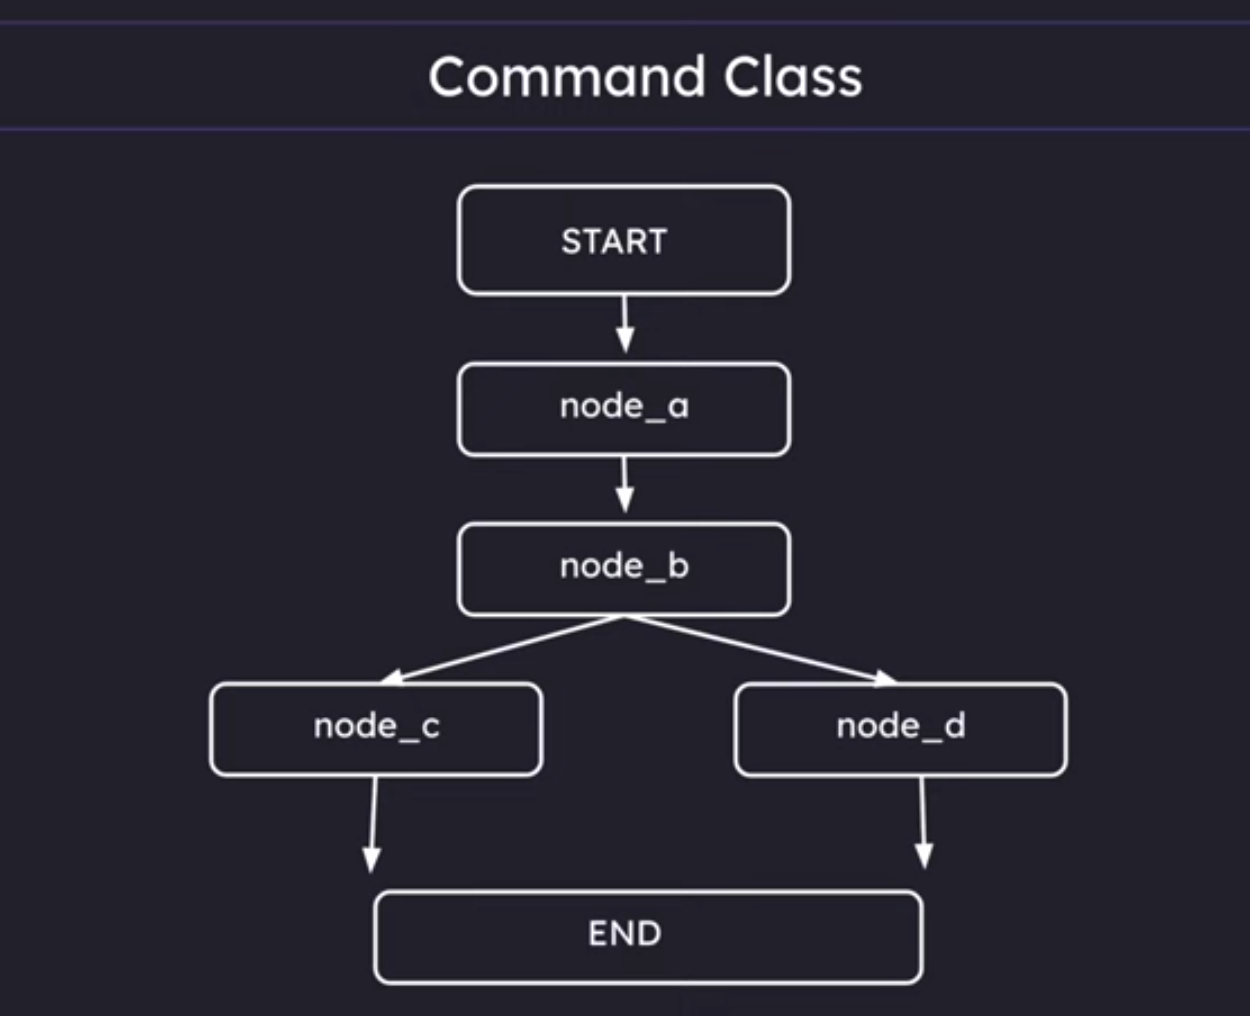

In [4]:

graph = StateGraph(State)

graph.add_node("node_a", node_a)
graph.add_node("node_b", node_b)
graph.add_node("node_c", node_c)
graph.add_node("node_d", node_d)

graph.set_entry_point("node_a") 

app = graph.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

initialState = {
    "value": ""
}


In [5]:
first_result = app.invoke(initialState, config, stream_mode="updates")
first_result

Node A
Node B


[{'node_a': {'value': 'a'}},
 {'__interrupt__': (Interrupt(value='Do you want to go to C or D? Type C/D', resumable=True, ns=['node_b:efbd0f83-79b0-fcba-8412-b78133f58677']),)}]

In [6]:
print(app.get_state(config).next)


('node_b',)


In [7]:
second_result = app.invoke(Command(resume="C"), config=config, stream_mode="updates")
second_result

Task node_c with path ('__pregel_pull', 'node_c') wrote to unknown channel branch:to:__end__, ignoring it.


Node B
Human Review Values:  C
Node C


[{'node_b': {'value': 'ab'}}, {'node_c': {'value': 'abc'}}]